# Import libraries

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Get data from api 
I get the weather data from ```https://archive-api.open-meteo.com/v1/archive``` this api. Furthermore in the below i am mentioning the peremeters in pass to the api. 
- lantitude = 23.7204
- longitude = 90.40.74  

In [2]:
import requests

# Define the API URL
api_url = "https://archive-api.open-meteo.com/v1/archive"

# Set the latitude and longitude for Dhaka
latitude = 23.7104
longitude = 90.4074

# Set the start and end dates
start_date = "2010-08-10"
end_date = "2023-08-24"

# Define the parameters for the API request
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    # "daily": "temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant",
    "daily": "temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max",
    "timezone": "auto",
}

# Send a GET request to the API
response = requests.get(api_url, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    # Process the data here
    df = pd.DataFrame(data['daily'])
else:
    print(f"Error: {response.status_code}")


In [3]:
df.shape

(4763, 5)

In [4]:
df.isna().sum()

time                  0
temperature_2m_max    0
temperature_2m_min    0
windspeed_10m_max     0
windgusts_10m_max     0
dtype: int64

In [5]:
df.dropna(inplace=True,axis=0)

In [6]:
# separate dates for future plottinh
train_dates = pd.to_datetime(df["time"])

In [7]:
print(train_dates.tail(15))

4748   2023-08-10
4749   2023-08-11
4750   2023-08-12
4751   2023-08-13
4752   2023-08-14
4753   2023-08-15
4754   2023-08-16
4755   2023-08-17
4756   2023-08-18
4757   2023-08-19
4758   2023-08-20
4759   2023-08-21
4760   2023-08-22
4761   2023-08-23
4762   2023-08-24
Name: time, dtype: datetime64[ns]


In [8]:
#variables for training 
cols = list(df)[1:]

In [9]:
cols

['temperature_2m_max',
 'temperature_2m_min',
 'windspeed_10m_max',
 'windgusts_10m_max']

In [10]:
df.columns

Index(['time', 'temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max',
       'windgusts_10m_max'],
      dtype='object')

In [11]:
#New dataframe with only training data - 6 columns
df_for_training = df[cols].astype(float)

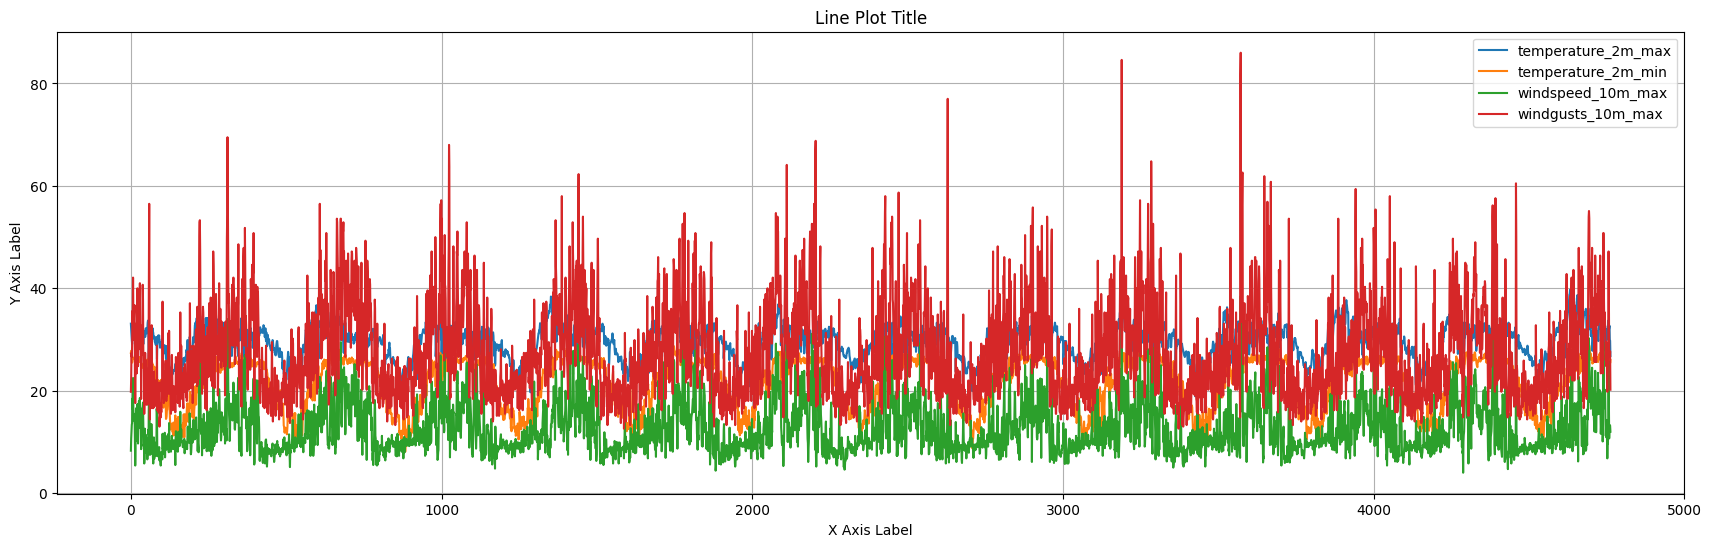

In [12]:
import matplotlib.pyplot as plt

# Specify the figure size
plt.figure(figsize=(21, 6))  # Adjust the width (10) and height (6) as needed

# Assuming you have a DataFrame called df_for_training
# Loop through each column and plot it on the same graph
for column in df_for_training.columns:
    plt.plot(df_for_training[column], label=column)

# Add labels and legend
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Line Plot Title')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [13]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [14]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []


In [15]:

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [16]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


In [17]:
pd.options.display.max_seq_items = 4000

In [18]:
df_for_training_scaled[:16]

array([[ 1.07650098,  1.15581485, -0.88522016, -0.84304193],
       [ 0.7465657 ,  1.2380521 , -0.38598345, -0.52729239],
       [ 0.38663631,  0.99134037, -0.07396051, -0.01556037],
       [ 0.11668927,  0.76518795,  0.17565785, -0.10266369],
       [-0.12326366,  0.76518795,  0.23806244,  0.13687045],
       [ 0.50661277,  0.80630657,  1.23653586,  0.87724869],
       [ 0.53660689,  0.95022174,  0.79970374,  0.6050508 ],
       [ 0.26665985,  0.95022174,  2.06859704,  1.58496318],
       [ 0.65658335,  0.90910312,  0.84130679,  0.72481787],
       [ 0.56660101,  0.95022174,  0.34207008,  0.25663751],
       [ 0.44662454,  0.90910312,  0.61248997,  0.72481787],
       [ 0.62658924,  0.90910312,  0.46687926,  0.87724869],
       [ 0.65658335,  1.01189968,  0.50848232,  0.99701576],
       [ 0.86654217,  1.03245899, -0.51079263, -0.52729239],
       [ 0.98651863,  1.03245899, -1.48846452, -1.08257607],
       [ 0.86654217,  0.97078106, -0.80201405, -0.45107698]])

In [19]:
trainY

[array([0.98651863]),
 array([0.86654217]),
 array([0.56660101]),
 array([0.41663043]),
 array([0.35664219]),
 array([0.62658924]),
 array([0.47661866]),
 array([0.47661866]),
 array([0.56660101]),
 array([0.80655393]),
 array([0.53660689]),
 array([0.38663631]),
 array([0.35664219]),
 array([0.47661866]),
 array([0.47661866]),
 array([0.41663043]),
 array([0.08669515]),
 array([0.35664219]),
 array([0.41663043]),
 array([0.44662454]),
 array([0.23666573]),
 array([-0.33322248]),
 array([-0.30322836]),
 array([-0.09326955]),
 array([0.23666573]),
 array([0.1766775]),
 array([-0.12326366]),
 array([0.11668927]),
 array([0.41663043]),
 array([0.50661277]),
 array([0.65658335]),
 array([0.44662454]),
 array([0.29665396]),
 array([0.38663631]),
 array([0.80655393]),
 array([0.56660101]),
 array([0.7465657]),
 array([0.50661277]),
 array([0.56660101]),
 array([0.80655393]),
 array([1.13648921]),
 array([1.25646567]),
 array([1.07650098]),
 array([-0.81312833]),
 array([-1.3230283]),
 array(

In [20]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [21]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4749, 14, 4).
trainY shape == (4749, 1).


In [22]:


model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu', return_sequences=True))  
# model.add(Dropout(0.1))
model.add(LSTM(16, activation='relu', return_sequences=True))  
model.add(LSTM(12, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


2023-08-30 20:23:02.163038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-30 20:23:02.163084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: SrvSh
2023-08-30 20:23:02.163088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: SrvSh
2023-08-30 20:23:02.163331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2023-08-30 20:23:02.163356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2023-08-30 20:23:02.163362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.104.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 14, 16)            3136      
                                                                 
 lstm_3 (LSTM)               (None, 12)                1392      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [23]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/30
268/268 [==============================] - 6s 10ms/step - loss: 0.4313 - val_loss: 0.3068
Epoch 2/30
268/268 [==============================] - 2s 9ms/step - loss: 0.2919 - val_loss: 0.3163
Epoch 3/30
268/268 [==============================] - 2s 8ms/step - loss: 0.2570 - val_loss: 0.2756
Epoch 4/30
268/268 [==============================] - 2s 8ms/step - loss: 0.2199 - val_loss: 0.1982
Epoch 5/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1914 - val_loss: 0.1689
Epoch 6/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1759 - val_loss: 0.1570
Epoch 7/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1713 - val_loss: 0.1636
Epoch 8/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1614 - val_loss: 0.1535
Epoch 9/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1609 - val_loss: 0.1860
Epoch 10/30
268/268 [==============================] - 2s 8ms/step - loss: 0.1573 - val_loss: 0.166

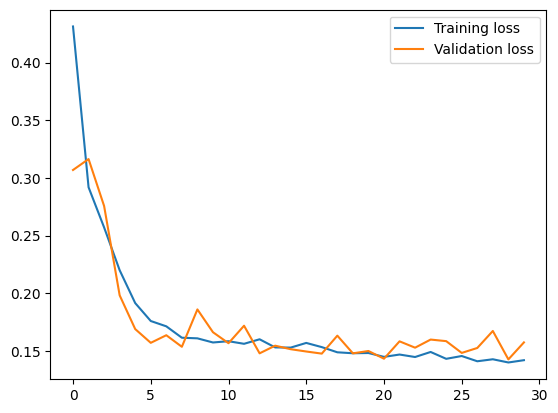

In [24]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [26]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2023-08-09 00:00:00'), Timestamp('2023-08-10 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-08-12 00:00:00'), Timestamp('2023-08-13 00:00:00'), Timestamp('2023-08-14 00:00:00'), Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2023-08-17 00:00:00'), Timestamp('2023-08-18 00:00:00'), Timestamp('2023-08-19 00:00:00'), Timestamp('2023-08-20 00:00:00'), Timestamp('2023-08-21 00:00:00'), Timestamp('2023-08-22 00:00:00'), Timestamp('2023-08-23 00:00:00')]


In [27]:
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 0s 291ms/step


In [28]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [29]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [30]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'temperature_2m_max':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [31]:
original = df[['time', 'temperature_2m_max']]
original['Date']=pd.to_datetime(original['time'])
original = original.loc[original['Date'] >= '2023-08-09']



/tmp/ipykernel_410502/2394950650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['time'])


In [32]:
df_forecast

,Date,temperature_2m_max
0,2023-08-09,31.991646
1,2023-08-10,31.072384
2,2023-08-11,31.222467
3,2023-08-12,30.873629
4,2023-08-13,30.505051
5,2023-08-14,31.694986
6,2023-08-15,31.708851
7,2023-08-16,31.810968
8,2023-08-17,32.137077
9,2023-08-18,30.718393


In [33]:
original

,time,temperature_2m_max,Date
4747,2023-08-09,31.8,2023-08-09
4748,2023-08-10,32.0,2023-08-10
4749,2023-08-11,31.7,2023-08-11
4750,2023-08-12,31.4,2023-08-12
4751,2023-08-13,30.0,2023-08-13
4752,2023-08-14,31.8,2023-08-14
4753,2023-08-15,32.6,2023-08-15
4754,2023-08-16,32.6,2023-08-16
4755,2023-08-17,33.7,2023-08-17
4756,2023-08-18,31.8,2023-08-18


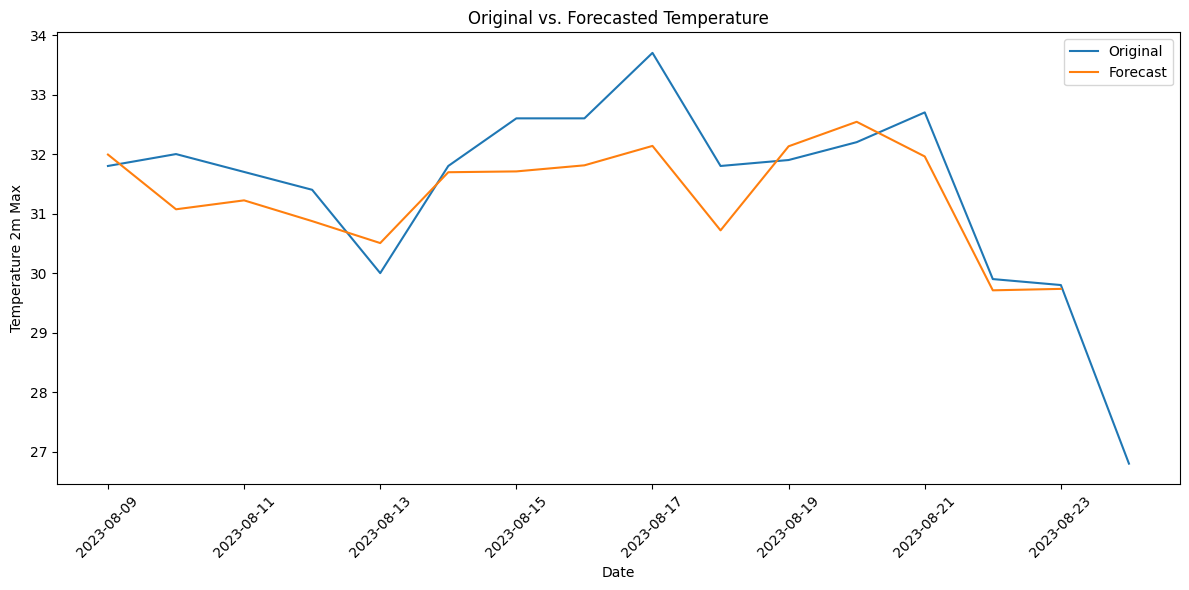

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.lineplot(data=original, x='Date', y='temperature_2m_max', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='temperature_2m_max', ax=ax, label='Forecast')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Temperature 2m Max')
ax.set_title('Original vs. Forecasted Temperature')
ax.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Ensure that labels are not cut off
plt.show()


In [35]:
n_future = 90
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [36]:
forecast = model.predict(trainX[-n_future:])

3/3 [==============================] - 0s 4ms/step


In [37]:
forecast_copies = np.repeat(forecast,df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [38]:
y_pred_future

array([31.616636, 31.561588, 32.885063, 33.22532 , 33.616016, 33.79759 ,
       33.45609 , 34.23068 , 34.185833, 34.18859 , 34.834827, 34.630417,
       34.079395, 30.376015, 28.597628, 29.824257, 30.04802 , 32.973312,
       31.65908 , 34.18159 , 32.456795, 32.83151 , 32.6026  , 32.544243,
       30.62766 , 31.32331 , 31.806467, 30.437822, 31.216658, 30.299452,
       30.842405, 30.072086, 28.851881, 29.422928, 30.303225, 31.281855,
       30.788404, 31.898695, 31.658117, 32.047134, 31.10145 , 29.90211 ,
       30.320232, 30.92439 , 32.281963, 29.853836, 30.595129, 31.556015,
       30.369585, 30.685093, 29.583824, 30.05536 , 31.597366, 32.081467,
       31.671953, 31.72861 , 31.07019 , 31.903616, 32.55961 , 32.425846,
       32.249287, 30.19926 , 31.017212, 32.088127, 31.974533, 32.982456,
       32.78688 , 31.019997, 29.96425 , 31.891094, 31.088966, 31.055162,
       29.518597, 29.226385, 29.3419  , 31.991646, 31.072384, 31.222467,
       30.873629, 30.50505 , 31.694986, 31.70885 , 

In [39]:
#convert timestamp to date
forecast_dates= []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [43]:
forecast_dates

[datetime.date(2023, 8, 24),
 datetime.date(2023, 8, 25),
 datetime.date(2023, 8, 26),
 datetime.date(2023, 8, 27),
 datetime.date(2023, 8, 28),
 datetime.date(2023, 8, 29),
 datetime.date(2023, 8, 30),
 datetime.date(2023, 8, 31),
 datetime.date(2023, 9, 1),
 datetime.date(2023, 9, 2),
 datetime.date(2023, 9, 3),
 datetime.date(2023, 9, 4),
 datetime.date(2023, 9, 5),
 datetime.date(2023, 9, 6),
 datetime.date(2023, 9, 7),
 datetime.date(2023, 9, 8),
 datetime.date(2023, 9, 9),
 datetime.date(2023, 9, 10),
 datetime.date(2023, 9, 11),
 datetime.date(2023, 9, 12),
 datetime.date(2023, 9, 13),
 datetime.date(2023, 9, 14),
 datetime.date(2023, 9, 15),
 datetime.date(2023, 9, 16),
 datetime.date(2023, 9, 17),
 datetime.date(2023, 9, 18),
 datetime.date(2023, 9, 19),
 datetime.date(2023, 9, 20),
 datetime.date(2023, 9, 21),
 datetime.date(2023, 9, 22),
 datetime.date(2023, 9, 23),
 datetime.date(2023, 9, 24),
 datetime.date(2023, 9, 25),
 datetime.date(2023, 9, 26),
 datetime.date(2023, 9,

In [40]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'temp' : y_pred_future})
df_forecast['Data'] = pd.to_datetime(df_forecast['Date'])

In [41]:
original = df[['time', 'temperature_2m_max']]
original['Date']=pd.to_datetime(original['time'])
original = original.loc[original['Date'] >= '2023-08-08']

/tmp/ipykernel_410502/2165663633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['time'])


In [45]:
df_forecast

,Date,temp,Data
0,2023-08-24,31.616636,2023-08-24
1,2023-08-25,31.561588,2023-08-25
2,2023-08-26,32.885063,2023-08-26
3,2023-08-27,33.225319,2023-08-27
4,2023-08-28,33.616016,2023-08-28
...,...,...,...
85,2023-11-17,32.130730,2023-11-17
86,2023-11-18,32.542133,2023-11-18
87,2023-11-19,31.959986,2023-11-19
88,2023-11-20,29.711229,2023-11-20


In [46]:
original

,time,temperature_2m_max,Date
4746,2023-08-08,27.8,2023-08-08
4747,2023-08-09,31.8,2023-08-09
4748,2023-08-10,32.0,2023-08-10
4749,2023-08-11,31.7,2023-08-11
4750,2023-08-12,31.4,2023-08-12
4751,2023-08-13,30.0,2023-08-13
4752,2023-08-14,31.8,2023-08-14
4753,2023-08-15,32.6,2023-08-15
4754,2023-08-16,32.6,2023-08-16
4755,2023-08-17,33.7,2023-08-17


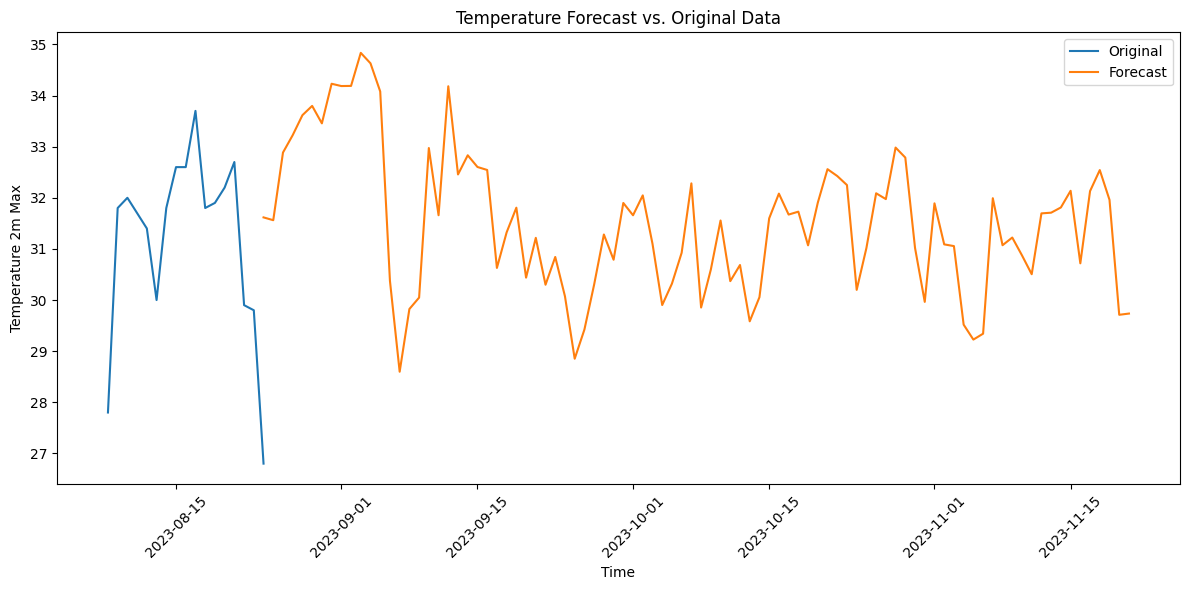

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.lineplot(data=original, x='Date', y='temperature_2m_max', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='temp', label='Forecast', ax=ax)

# Set labels and legends
plt.xlabel('Time')
plt.ylabel('Temperature 2m Max')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Optionally, rotate x-axis labels for better readability
plt.title('Temperature Forecast vs. Original Data')
plt.tight_layout()  # Ensure proper spacing
plt.show()
